In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
from deeplift.dinuc_shuffle import dinuc_shuffle
import json
import os
import gzip
from math import log
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,2"
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [3]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("../data/models/max_hela_1_matched_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [4]:
max_lib2_keyToSeq = {}
max_rept_keyToSeq = {}
max_lib2_keyToDdG = {}
max_rept_keyToDdG = {}

In [7]:
!head ../data/experimental/lib2_mean_ddGs_excludedegenerate.csv

name,sequence,Pho4_mean_ddG,Max_mean_ddG
Rand_long1,CGCCCCAGCACTGCCAAGCCGACGTTAAAACGGGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCTTGAGTGCATCGAATAGTTCGGTTTATGAGCGTCCGGCGGTATGAC,0.0,0.0
GT_AC_45bp,CGCCCCAGCACTGCCAAGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTCACGTGACACACACACACACACACACACACACACACACACACACACACACACAAGTTCGGTTTATGAGCGTCCGGCGGTATGAC,-0.6778106530502541,-0.13632404766909867
GC_GC_repeat,CGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGTCACGTGACGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCCGTCCGGCGGTATGAC,-0.6175501334109968,-0.6428362367973494
GC_AT_30+30+0,CGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCTATATATATATATATATATATATATATATACGTCCGGCGGTATGAC,-0.613228447720681,-0.6380198071302782
GA_CT_30+30+0,CGCGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGTTGCTTCATCAATCGAATGTCAATACATAGTCACGTGACACGCGGTAGGCTCGCTATCGGCACTTGCGCCTCTCTCTCTCTCTCTCTCTCTCTCTCTCTCGTCCGGCGGTATGAC,-0.175613341314786

In [8]:
!head ../data/experimental/lib1_mean_ddGs.csv

name,sequence,Pho4_mean_ddG,Max_mean_ddG
Motif_and_repeat_strong_5,CGCTGTGTGTGTGTGTGTCACGTGACACACACCACAAACGTCCGGCGGTATGAC,0.0,0.0
Motif_and_half_repeat_strong_12,CGCAAGGCTTGTGTGTGTCACGTGACACCACACATCGATGTCCGGCGGTATGAC,0.3894316305681954,-0.054177249724240414
CACGCG_RAND5,CGCACAGTCACTTAACGTCACGCGACCGGGGTATTTCAGGTCCGGCGGTATGAC,1.4670066671588076,1.3299561013868155
No_Motif_No_Repeat1,CGCCGCAGAGTCTCATTCTCCATACGCTGTAAAGTGGGAGTCCGGCGGTATGAC,1.728111359856401,1.434723755929844
Motif_and_repeat_strong_6,CGCATATATATATAGAGTCACGTGACTCTCGCGCGCGCGGTCCGGCGGTATGAC,0.17671646928607426,-0.1706078971117761
Motif_and_half_repeat_strong_14,CGCAGTGACGCGCAGAGTCACGTGACTCTATATTACGCTGTCCGGCGGTATGAC,0.7389271322412421,-0.10774786746869981
CACGCG_RAND8,CGCGATCGGCGCGGACGTCACGCGACCTCTAATTTTAAAGTCCGGCGGTATGAC,1.593243812268279,1.2099839444057396
No_Motif_No_Repeat2,CGCCCTGTCGGGAAAGACCATTGTTCTCTAAAGAGCTCGGTCCGGCGGTATGAC,1.8070692327794484,1.3918797069422961
Motif_and_repeat_strong_10,CGCTGTGTGTGTGTGTGTCACGTGACACACAA

In [10]:
firstLine = True
with open("../data/experimental/lib2_mean_ddGs_excludedegenerate.csv", encoding='utf-8-sig') as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        max_lib2_keyToSeq[line.strip().split(',')[0]] = line.strip().split(',')[1]
        max_lib2_keyToDdG[line.strip().split(',')[0]] = float(line.strip().split(',')[-1])

In [11]:
firstLine = True
with open("../data/experimental/lib1_mean_ddGs.csv", encoding='utf-8-sig') as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        max_rept_keyToSeq[line.strip().split(',')[0]] = line.strip().split(',')[1]
        max_rept_keyToDdG[line.strip().split(',')[0]] = float(line.strip().split(',')[-1])

In [12]:
fastapath = "../data/genome/hg38/hg38.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 1346
out_pred_len = 1000
test_chrms = ["chr1", "chr8", "chr21"]
seq_peaks = []
with gzip.open("../data/gcpbm/max_hela_1/idr.optimal_peak.narrowPeak.gz", 'rt') as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + int(line.strip().split('\t')[-1])
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        seq_peaks.append(GenomeDict[chrm][start:end].upper())
    
ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

In [13]:
def fill_into_center(seq, insert):
    flank = int((len(seq)-len(insert))/2.0)
    new_seq = seq[:flank]+insert+seq[flank+len(insert):]
    return new_seq

In [14]:
from deeplift.dinuc_shuffle import dinuc_shuffle
num_samples = 100
indices = np.random.choice(len(seq_peaks), num_samples, replace=False)
yvals_lib2 = {}
for key in max_lib2_keyToSeq:
    pre_seqs = []
    post_seqs = []
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        post_seq = fill_into_center(pre_seq, max_lib2_keyToSeq[key])
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals_lib2[key] = np.mean(post[0]-pre[0])

In [15]:
yvals_rept = {}
for key in max_rept_keyToSeq:
    pre_seqs = []
    post_seqs = []
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        post_seq = fill_into_center(pre_seq, max_rept_keyToSeq[key])
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals_rept[key] = np.mean(post[0]-pre[0])

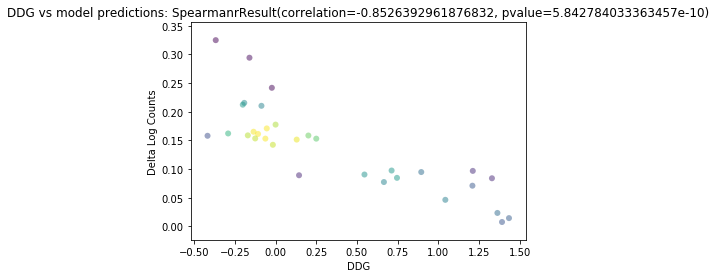

In [16]:
xvals = []
yvals = []
for key in max_rept_keyToSeq:
    yvals.append(yvals_rept[key])
    xvals.append(max_rept_keyToDdG[key])
    
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

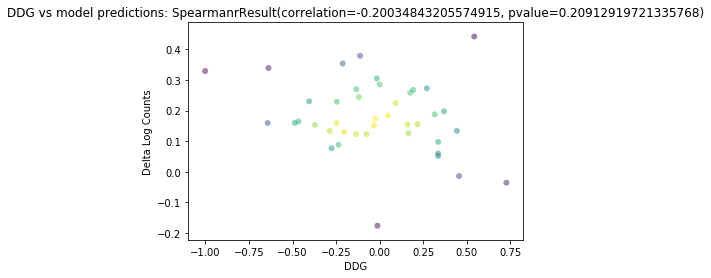

In [17]:
xvals = []
yvals = []
for key in max_lib2_keyToSeq:
    yvals.append(yvals_lib2[key])
    xvals.append(max_lib2_keyToDdG[key])
    
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

In [19]:
f = open('../data/preds/max_hela_1_matched_lib2_preds.csv','w')
for key in max_lib2_keyToSeq:
    if key == 'background': continue
    f.write(key+','+max_lib2_keyToSeq[key]+','+str(yvals_lib2[key])+'\n')
f.close()
!head data/preds/max_hela_1_lib2_preds.csv
f = open('../data/preds/max_hela_1_matched_rept_preds.csv','w')
for key in max_rept_keyToSeq:
    if key == 'background': continue
    f.write(key+','+max_rept_keyToSeq[key]+','+str(yvals_rept[key])+'\n')
f.close()
!head data/preds/max_hela_1_rept_preds.csv

head: cannot open 'data/preds/max_hela_1_lib2_preds.csv' for reading: No such file or directory
head: cannot open 'data/preds/max_hela_1_rept_preds.csv' for reading: No such file or directory
